# Optimization of Sales

#### Imports

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sb
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
!pip install pulp
from pulp import *

## The advertising dataset that we have used in this project.

In [2]:
df = pd.read_csv("advertising.csv")

In [3]:
## Here we display the database 

In [4]:
df

,TV,Radio,Newspaper,Sales
0,230.1,37.8,69.2,22.1
1,44.5,39.3,45.1,10.4
2,17.2,45.9,69.3,12.0
3,151.5,41.3,58.5,16.5
4,180.8,10.8,58.4,17.9
...,...,...,...,...
195,38.2,3.7,13.8,7.6
196,94.2,4.9,8.1,14.0
197,177.0,9.3,6.4,14.8
198,283.6,42.0,66.2,25.5


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   TV         200 non-null    float64
 1   Radio      200 non-null    float64
 2   Newspaper  200 non-null    float64
 3   Sales      200 non-null    float64
dtypes: float64(4)
memory usage: 6.4 KB


In [6]:
df.describe()

,TV,Radio,Newspaper,Sales
count,200.000000,200.000000,200.000000,200.000000
mean,147.042500,23.264000,30.554000,15.130500
std,85.854236,14.846809,21.778621,5.283892
min,0.700000,0.000000,0.300000,1.600000
25%,74.375000,9.975000,12.750000,11.000000
50%,149.750000,22.900000,25.750000,16.000000
75%,218.825000,36.525000,45.100000,19.050000
max,296.400000,49.600000,114.000000,27.000000


In [7]:
df.mean()

TV           147.0425
Radio         23.2640
Newspaper     30.5540
Sales         15.1305
dtype: float64

- **Here we can see that the dataset comprises 200 data points for each of the data variables, i.e., TV, Radio, Newspaper, and Sales. Columns "TV", "Radio", and "Newspaper" have recorded data for the budget in thousands of dollars. Column "Sales" has recorded data for the sales in thousands of units.**
- **The dataset gives one the opportunity to design an optimization problem of maximizing sales around a set of assumed constraints**

#### Visualizations

**Pair plots**

*Here we compare the sales of each data variable*

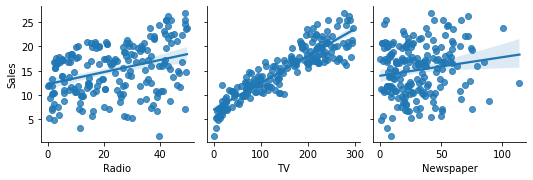

In [8]:
sb.pairplot(df, x_vars=["Radio","TV","Newspaper"],y_vars= "Sales",kind="reg")

*Comparing data variables*

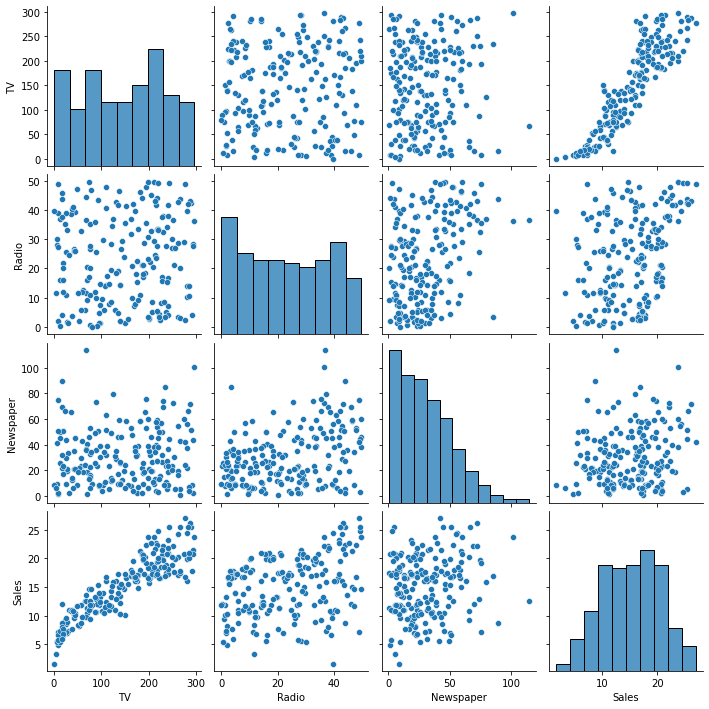

In [9]:
sb.pairplot(df);

**Correlation heatmap**

*Correlation between different variables*

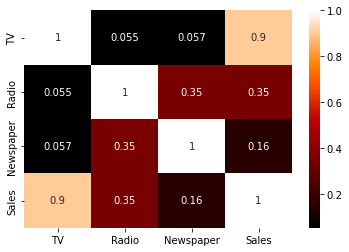

In [10]:
corr = df.corr()
sb.heatmap(corr, cmap ='gist_heat', annot =True);

**Residual plots**

Here we compare the sales of data variables with each other

*TV Vs Sales*

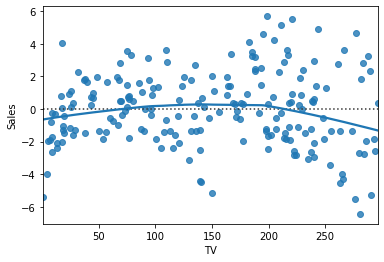

In [11]:
sb.residplot(x = df['TV'], y = df['Sales'], lowess = True);

*Radio Vs Sales*

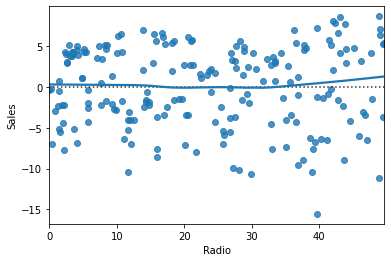

In [12]:
sb.residplot(x = df['Radio'], y = df['Sales'], lowess = True);

*Newspaper Vs Sales*

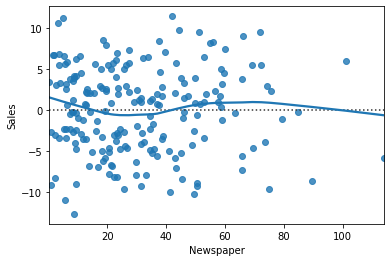

In [13]:
sb.residplot(x = df['Newspaper'], y = df['Sales'], lowess = True);

**Adding an extra column for average budget**

In [14]:
df['Average Budget'] = df[['TV', 'Radio', 'Newspaper']].mean(numeric_only=True, axis=1)
df

,TV,Radio,Newspaper,Sales,Average Budget
0,230.1,37.8,69.2,22.1,112.366667
1,44.5,39.3,45.1,10.4,42.966667
2,17.2,45.9,69.3,12.0,44.133333
3,151.5,41.3,58.5,16.5,83.766667
4,180.8,10.8,58.4,17.9,83.333333
...,...,...,...,...,...
195,38.2,3.7,13.8,7.6,18.566667
196,94.2,4.9,8.1,14.0,35.733333
197,177.0,9.3,6.4,14.8,64.233333
198,283.6,42.0,66.2,25.5,130.600000


**Scatter plot**

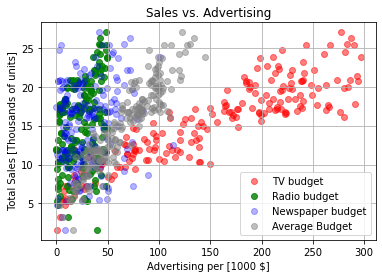

In [15]:
plt.scatter(df['TV'],df['Sales'],c="red",alpha=0.5, label='TV budget')
plt.scatter(df['Radio'],df['Sales'],c="green",alpha=0.8, label='Radio budget')
plt.scatter(df['Newspaper'],df['Sales'],c="blue",alpha=0.3, label= 'Newspaper budget')
plt.scatter(df['Average Budget'],df['Sales'],c="gray",alpha=0.5, label= 'Average Budget')
plt.legend(loc="lower right")
plt.title("Sales vs. Advertising")
plt.xlabel("Advertising per [1000 $]")
plt.ylabel(" Total Sales [Thousands of units]")
plt.grid()
plt.show()

#### Optimization Problem

**Problem Statement:** 

1. A budget constraint restricting the total amount of money to be allocated among three different channels (TV, Radio, Newspaper) takes the form x1 + x2 + x3 ≤ B, where B is the budget.

2. The total spend for each of these channels (TV, Radio, Newspaper) should be less than or equal to some constraints t, r, and n while total budget is capped at B.

3. Find out the objective function where we plan to maximize or minimize sales.


**Approach:** 

1. Set constraint limits to variables B (total budget), t (TV), r (Radio), and Newspaper (n).

2. Build a linear regression model using the set constraints and data. Construct an objective function from the acquired results.

3. Maximize or Minimize for a desired output using linear programming (use python's PuLP).

In [16]:
y = df['Sales']
x = df[['Average Budget']]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=57)

**Linear Regression**

In [17]:
regression = LinearRegression()
regression.fit(x_train,y_train)
rgs_y_pred = regression.predict(x_test)
rgs_score = regression.score(x_test, y_test)
rgs_MSE = np.sqrt(mean_squared_error(y_test,rgs_y_pred))
rgs_coef = regression.coef_
rgs_intercept = regression.intercept_
print("The Score is: ", rgs_score)
print("The Error is: ", rgs_MSE)
print("The coef is: ",rgs_coef)
print("The intercept is: ",rgs_intercept)

The Score is:  0.8723010124704045
The Error is:  2.0260166547322767
The coef is:  [0.15518937]
The intercept is:  4.671512412906932


Text(0.5, 0, 'Y test')

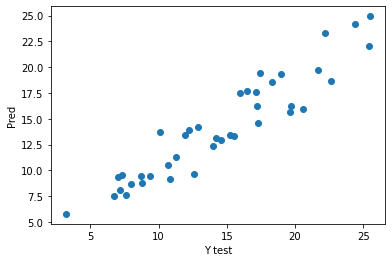

In [18]:
plt.scatter(y_test,rgs_y_pred)
plt.ylabel('Pred')
plt.xlabel('Y test')

**Lasso Model**

In [19]:
lasso = Lasso(alpha= 0.01)
lasso.fit(x_train,y_train)
lss_y_pred = lasso.predict(x_test)
lss_score = lasso.score(x_test, y_test)
lss_MSE = np.sqrt(mean_squared_error(y_test,lss_y_pred))
lss_coef = lasso.coef_
lss_intercept = lasso.intercept_
print("The Score is: ", lss_score)
print("The Error is: ", lss_MSE)
print("The coef is: ",lss_coef)
print("The intercept is: ",lss_intercept)

The Score is:  0.8722934450614519
The Error is:  2.0260766844542673
The coef is:  [0.1551787]
The intercept is:  4.672242463039764


Text(0.5, 0, 'Y test')

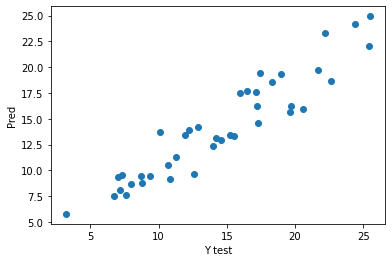

In [20]:
plt.scatter(y_test,lss_y_pred)
plt.ylabel('Pred')
plt.xlabel('Y test')

**Ridge Model**

In [21]:
rr = Ridge(alpha=0.01)
rr.fit(x_train, y_train) 
rr_y_pred= rr.predict(x_test)
rr_score = rr.score(x_test, y_test)
rr_MSE = np.sqrt(mean_squared_error(y_test,rr_y_pred))
rr_coef = rr.coef_
rr_intercept = rr.intercept_
print("The Score is: ", rr_score)
print("The Error is: ", rr_MSE)
print("The coef is: ",rr_coef)
print("The intercept is: ",rr_intercept)

The Score is:  0.8723010051341012
The Error is:  2.0260167129295756
The coef is:  [0.15518936]
The intercept is:  4.671513121007029


Text(0.5, 0, 'Y test')

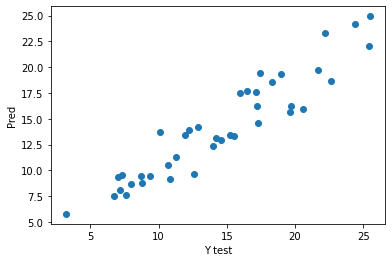

In [22]:
plt.scatter(y_test,rr_y_pred)
plt.ylabel('Pred')
plt.xlabel('Y test')

**Elastic Net**

In [23]:
enet = ElasticNet(alpha = 0.01)
enet.fit(x_train, y_train) 
enet_y_pred = enet.predict(x_test)
enet_score = enet.score(x_test, y_test)
enet_MSE = np.sqrt(mean_squared_error(y_test,enet_y_pred))
enet_coef = enet.coef_
enet_intercept = enet.intercept_
print("The Score is: ", enet_score)
print("The Error is: ", enet_MSE)
print("The coef is: ",enet_coef)
print("The intercept is: ",enet_intercept)

The Score is:  0.8722966425000338
The Error is:  2.026051320461346
The coef is:  [0.15518321]
The intercept is:  4.671934083734499


Text(0.5, 0, 'Y test')

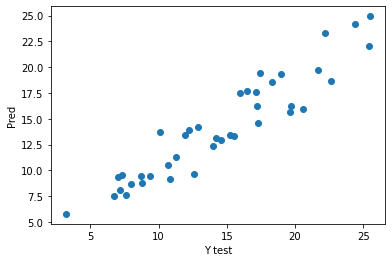

In [24]:
plt.scatter(y_test,enet_y_pred)
plt.ylabel('Pred')
plt.xlabel('Y test')

In [25]:
avg_coef = (rgs_coef+lss_coef+rr_coef+enet_coef)/4
avg_intercept = (rgs_intercept+lss_intercept+rr_intercept+enet_intercept)/4
print(avg_coef)
print(avg_intercept)

[0.15518516]
4.671800520172056


Text(0.5, 0, 'Avg Intercept')

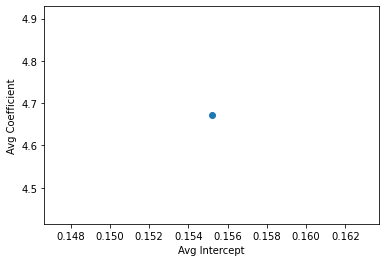

In [26]:
plt.scatter(avg_coef,avg_intercept)
plt.ylabel('Avg Coefficient')
plt.xlabel('Avg Intercept')

**Constraints:**

Let the constraint on the total budget B be 1000, i.e., (T+R+N) <= 1000.

Let the constraint on each of the channels be as follows:
T <= 200
R <= 500
N <= 500

*Objective Function to Maximize Sales using PuLP*

Maximize Sales, S = 0.05367932(T) + 0.11150177(R) - 0.0034977(N) + 4.773466912078015

In [27]:
OpProb = LpProblem("AdvsSalesOpt", LpMaximize)
T = LpVariable("TV", 0, 200)
R = LpVariable("Radio", 0, 500)
N = LpVariable("Newspaper", 0, 500)
OpProb += T + R + N <= 1000
OpProb +=  0.05367932*T + 0.11150177*R - 0.0034977*N + 4.773466912078015
status = OpProb.solve()
LpStatus[status]

'Optimal'

In [28]:
print(OpProb)
for v in OpProb.variables():
    print(v.name, "=", v.varValue)

AdvsSalesOpt:
MAXIMIZE
-0.0034977*Newspaper + 0.11150177*Radio + 0.05367932*TV + 4.773466912078015
SUBJECT TO
_C1: Newspaper + Radio + TV <= 1000

VARIABLES
Newspaper <= 500 Continuous
Radio <= 500 Continuous
TV <= 200 Continuous

Newspaper = 0.0
Radio = 500.0
TV = 200.0


In [29]:
print("Objective Value = %f" % (OpProb.objective.value()))


Objective Value = 71.260216


In [30]:
# Optimized Value for Sales, Confirmation through calculation

OptVal = 0.05368006*200 + 0.11152624*500 - 0.00351166*0 + 4.773205203269837
print("Optimized Budget Sales: ",OptVal)

Optimized Budget Sales:  71.27233720326984
